In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
cwd = "/content/drive/My Drive/Rakuten/"
os.chdir(cwd)


os.getcwd()

'/content/drive/My Drive/Rakuten'

# **Imports, hyperparametres et variables**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import seaborn as sns
from tqdm import tqdm
import random
import cv2
import os
import tensorflow as tf
import nltk
nltk.download("stopwords") 
nltk.download('punkt')
import io, re, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('french'))
from nltk.stem.snowball import FrenchStemmer

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout, Input, Embedding, GlobalAveragePooling1D,  GlobalAveragePooling2D,RNN, GRUCell, LSTM, Dense,Flatten,Concatenate,Conv1D,MaxPooling1D,Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras import callbacks
tf.executing_eagerly()

from sklearn.model_selection import train_test_split
from sklearn import metrics
import itertools

In [ ]:
import seaborn as sns

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

In [ ]:
seed=0
test_size=0.1
val_size=0.2
IMG_SIZE = 299 
CHANNELS = 3 
path_to_images="/content/drive/My Drive/Rakuten/images/image_train"

# **Lecture des données et pré traitement**

In [ ]:
data=pd.read_csv('X_train_update.csv', index_col=0)
target=pd.read_csv("Y_train_CVw08PX.csv", index_col=0)
df=pd.concat([data,target ] , axis=1)

In [ ]:
print(df.shape)
df.head(3)

(84916, 5)


,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50


In [ ]:
# Ajout du chemin des images dans le dataframe
df['image_path']=""
for path in os.listdir(path_to_images):
    #On extrait le code image du nom du fichier
    image_id=path.split("_")[1]
    if int(image_id) in list(df['imageid']):
      df.loc[df[df['imageid']==int(image_id)].index, "image_path"]=path_to_images+"/"+path

# Enregistrement du dataframe pour éviter de rééxecuter l'opération
df.to_csv("df.csv", index=False) 


In [ ]:
df=pd.read_csv('df.csv')
df.head()

,designation,description,productid,imageid,prdtypecode,image_path
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,./images/image_train/image_1263597046_product_...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,./images/image_train/image_1008141237_product_...
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50,./images/image_train/image_938777978_product_2...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280,./images/image_train/image_457047496_product_5...
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705,./images/image_train/image_1077757786_product_...


### **1. Preprocessing**









> Cette partie concerne les données texte. Comme la colonne description contient plus de 40% de données manquantes et compte tenu du bruitsd'information qu'elle contient ainsi que pour des raisons liées à la vitesse d'entrainnement des modèles, nous avons fait abstraction de cette colonne et nous avons utilisé uniquement la colonne désignation.


> Suite aux étapes data visualisation et data analyse, nous avons pu constater differents pré traitements à réaliser sur les données:  
remplacement des lettres avec des accents encodés en html supression des balises html et des stopwords

In [ ]:
df['class']=df['prdtypecode'].replace(list(df['prdtypecode'].unique()), [i for i in range(27)])
df=df[["designation","image_path","class"]]


In [ ]:

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')
    
def remplace_accent(x):
    cd=pd.isnull(x)
    if cd==True:
        return x
    accent = ['é', 'è', 'ê', 'à', 'ù', 'û', 'ç', 'ô', 'î', 'ï', 'â','&acirc;','&agrave;','&eacute;','&ecirc;','&egrave;','&euml;','&icirc;','&iuml;','&ocirc;','&oelig;','&ucirc;','&ugrave;','&uuml;','&ccedil;','&lt;','&gt;','&szlig;','&oslash;','&Omega;','&ETH;','&Oslash;','&THORN;','&thorn;','&Aring;']
    sans_accent = ['e', 'e', 'e', 'a', 'u', 'u', 'c', 'o', 'i', 'i', 'a','a','a','e','e','e','e','i','i','o','oe','u','u','u','c',' ',' ','',' ',' ',' ',' ',' ',' ','A']
    for c, s in zip(accent, sans_accent):
        x = x.replace(c, s)
        return x

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    w=remplace_accent(w)
    #removing html tags
    w=re.sub('<[^<]+?>', '', w)
    # creating a space between a word and the punctuation following it
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    #Remove words of length less than 1
    w=re.sub(r'\b\w{,1}\b', '', w)
     # remove stopword
    mots = word_tokenize(w.strip())
    stemmer =  FrenchStemmer()
    mots = [stemmer.stem(mot) for mot in mots if mot not in stop_words]
    return ' '.join(mots).strip()
    


df.designation = df.designation.apply(lambda x : preprocess_sentence(x))

### **2. Calcul de la taille maximum d'une séquence de mot**

Afin de représenter les données text en données numériques compréhensible par un modèle de deep learning, nous avons besoin de définir une taille maximum de sequences de mots.   
Ci dessous une représentation du nombre de mots par séquence (ligne du dataframe)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


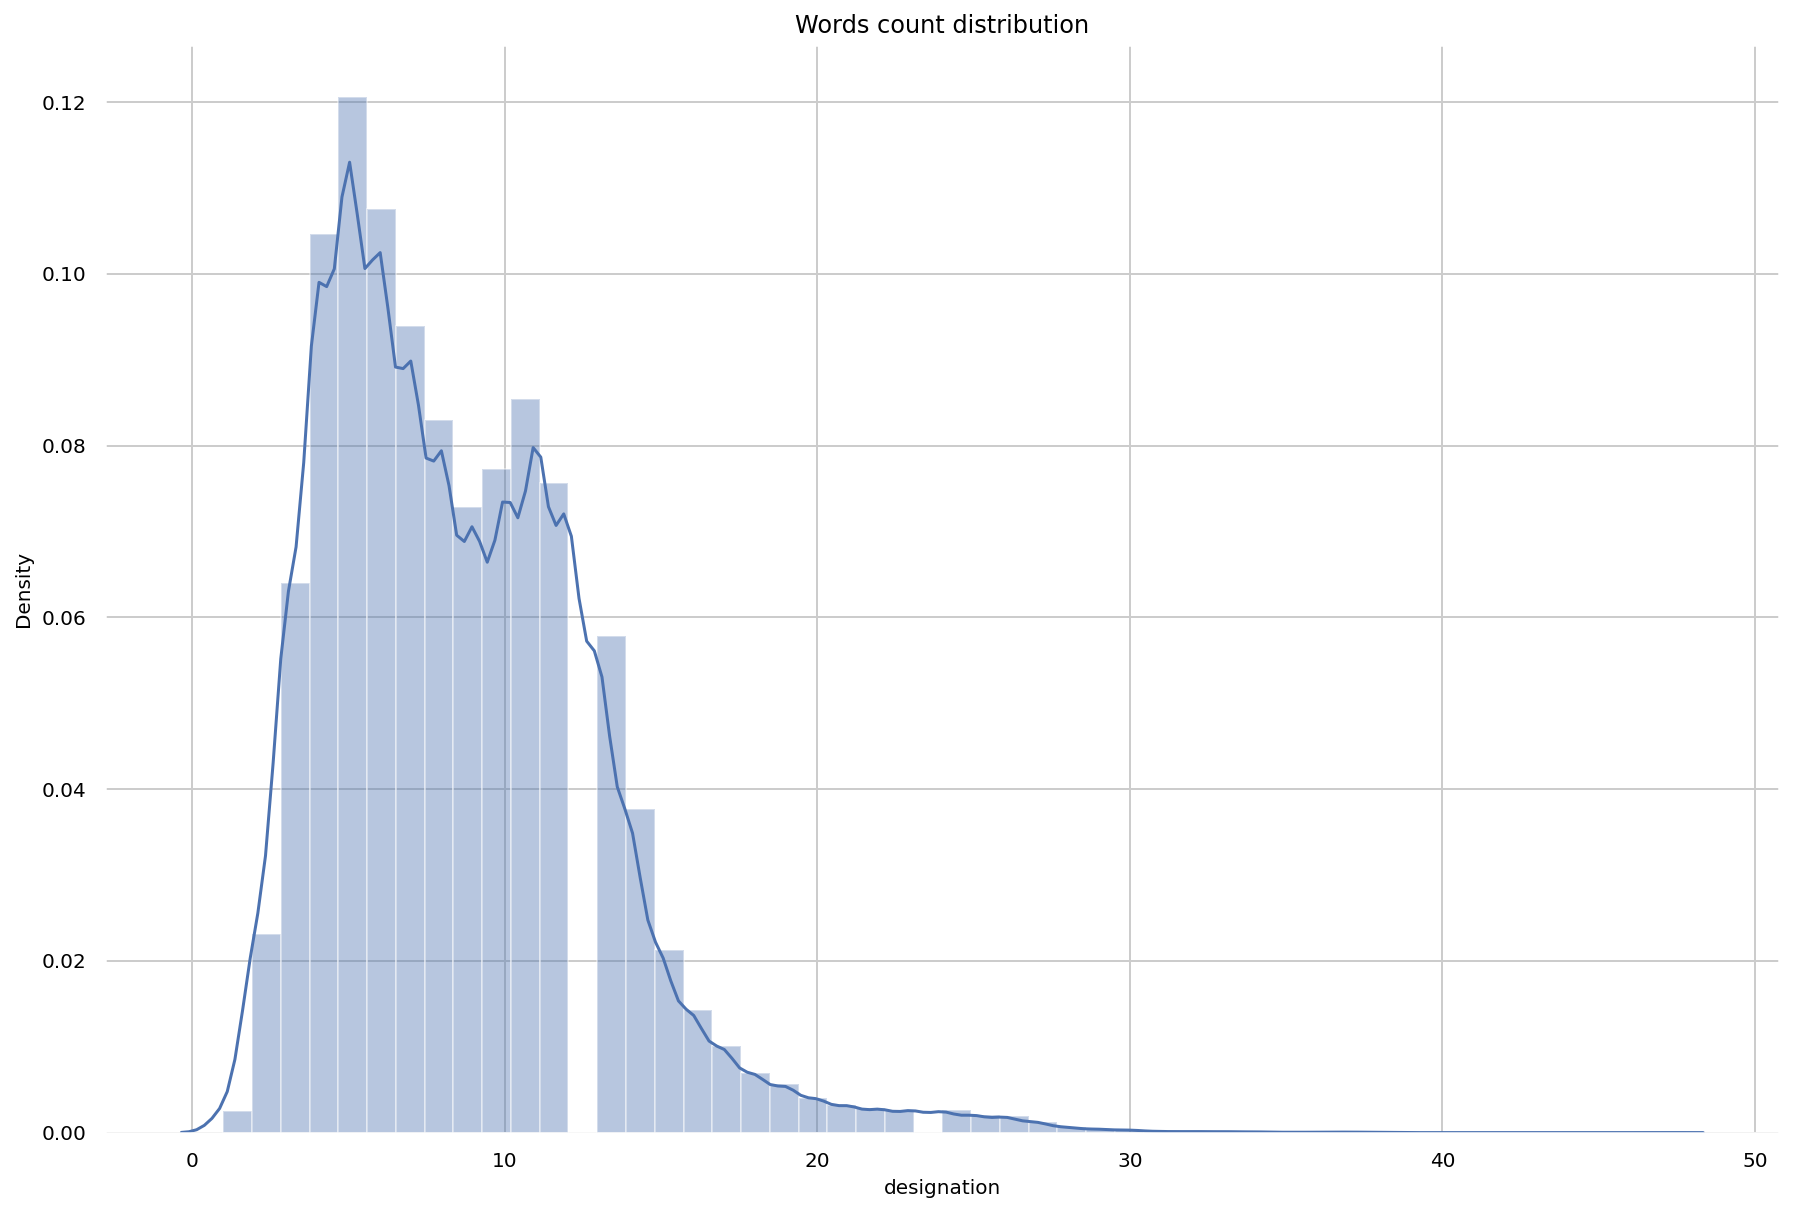

In [ ]:

word_count = df.designation.apply(lambda x : len(x.split(' ')))
plt.figure(figsize=(15,10))
sns.distplot(word_count)
plt.title("Words count distribution")
plt.show()

In [ ]:
df.head()

,designation,image_path,class
0,olivi personalisiert notizbuch seiten punktras...,./images/image_train/image_1263597046_product_...,0
1,journal art art march salon art asiat paris ja...,./images/image_train/image_1008141237_product_...,1
2,grand stylet ergonom bleu gamepad nintendo wii...,./images/image_train/image_938777978_product_2...,2
3,peluch donald europ disneyland marionnet doigt,./images/image_train/image_457047496_product_5...,3
4,guerr tuqu,./images/image_train/image_1077757786_product_...,4


In [ ]:
print("95% des lignes contiennent moins de {} mots ." .format(word_count.quantile(0.95)))

95% des lignes contiennent moins de 16.0 mots .


Par la suite nous choisissons une taille max de 17 mots par séquence

### **3. Split des données d'entrainement , validation et test**

In [ ]:

# on extrait d'abord les données test
X_text, X_text_test, y, y_test = train_test_split(df[['designation','image_path']], df['class'], test_size=test_size, random_state=seed)

In [ ]:
#Puis on split en données train et validation 
X_text_train, X_text_val, y_train, y_val = train_test_split(X_text, y, test_size=val_size, random_state=0)

### **4. Tokenisation des mots et padding**

Tokenization

In [ ]:
# On transforme les données text en tokens numériques , transformation qui pour chaque mot lui affect son indice dans le dictionnaire

# Définition du tokenizer
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=46000)
# Mettre à jour le dictionnaire du tokenizer
tokenizer.fit_on_texts(X_text_train['designation'])

In [ ]:
X_train = tokenizer.texts_to_sequences(X_text_train['designation'])
X_val = tokenizer.texts_to_sequences(X_text_val['designation'])
X_test = tokenizer.texts_to_sequences(X_text_test['designation'])

In [ ]:
X_train[0]

[4, 1646, 1666, 1117, 71, 1778, 1537, 595, 1182, 3374]

In [ ]:
vocab_size

46000

Padding

In [ ]:
maxlen = 17
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, padding='post')
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, maxlen=maxlen, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, padding='post')


In [ ]:
X_train[0]

array([   4, 1646, 1666, 1117,   71, 1778, 1537,  595, 1182, 3374,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [ ]:
# Je transforme les target en onehote encoding
y_train_ohe=pd.get_dummies(y_train)
y_val_ohe=pd.get_dummies(y_val)
y_test_ohe=pd.get_dummies(y_test)

# **Modelisation**

La métrique à utiliser sur ce jeu de données est la métrique F1_score (nous avons choisi la macro comme notre dataset n'est pas très équilibré)  
Ci dessous nous avons implémenté la métrique F1 , ainsi que la loss qui cherche à maximiser cette métrique

### **1. F1 _loss function et F1_metric**

In [ ]:
#Loss

@tf.function
def macro_soft_f1(y, y_hat):
    
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    # on multiplie la proba prédite d'une classe (y_hat) par son label => Uniquement les probas des vrais positifs seront non nuls
    tp = tf.reduce_sum(y_hat * y, axis=0) 
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    #  calcul du F1 score , 1e-16 pour ne pas diviser par 0
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    # comme on cherche a maximiser F1_score , et qu'il nous faut une fonction coût à minimiser on calcul le cout= 1 - soft-f1 
    cost = 1 - soft_f1 
    # on fait la moyenne pour tous les labels du batch
    macro_cost = tf.reduce_mean(cost) 
    return macro_cost

In [ ]:
#Metric

@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

### **2. Construction des modèles**




In [ ]:
# rnn
def rnn(kind, shape, embedding_dim,voc_size_inp,seed=seed):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  inp = Input(shape=shape, dtype='int32', name='text_input')
  text_embedding = Embedding(voc_size_inp, embedding_dim)(inp)
  if kind=="bi_lstm":
    #hidden_layer = Bidirectional(LSTM(128,return_sequences=True, recurrent_dropout=0.2))(text_embedding)
    #drop_out=Dropout(0.3)(hidden_layer)
    hidden_layer = Bidirectional(LSTM(128, recurrent_dropout=0.2))(text_embedding)
    drop_out=Dropout(0.3)(hidden_layer)
  elif kind=="lstm":
    #hidden_layer = LSTM(128,return_sequences=True, recurrent_dropout=0.2)(text_embedding)
    #drop_out=Dropout(0.3)(hidden_layer)
    hidden_layer =LSTM(64, recurrent_dropout=0.2)(text_embedding)
    drop_out=Dropout(0.3)(hidden_layer)
  elif kind=="gru":
    #hidden_layer =RNN(GRUCell(128,return_sequences=True, recurrent_dropout=0.2))(text_embedding)
    #drop_out=Dropout(0.3)(hidden_layer)
    hidden_layer =RNN(GRUCell(64, recurrent_dropout=0.2))(text_embedding)
    drop_out=Dropout(0.3)(hidden_layer)
  else:
     raise TypeError("type de RNN non saisi")

  l_flat=Flatten()(drop_out)
  l_dense = Dense(128, activation='relu')(l_flat)
  l_dropout=Dropout(0.2)(l_dense)
  preds = Dense(27, activation='softmax')(l_dropout)
  model = Model(inputs=inp, outputs=preds, name="rnn_model")
  model.summary()
  return model


 

In [ ]:
# cnn
def cnn(kind, shape, embedding_dim,voc_size_inp,seed=seed):
  np.random.seed(seed)
  tf.random.set_seed(seed)
  inp = Input(shape=shape, dtype='int32', name='text_input')
  text_embedding = Embedding(voc_size_inp, embedding_dim)(inp)
  l_cov1= Conv1D(128, 3, activation='relu')(text_embedding)
  l_pool1 = MaxPooling1D(2)(l_cov1)
  l_cov2 = Conv1D(128, 3, activation='relu')(l_pool1)
  hidden_layer = MaxPooling1D(2)(l_cov2)
  l_flat=Flatten()(hidden_layer)
  l_dense = Dense(128, activation='relu')(l_flat)
  l_dropout=Dropout(0.2)(l_dense)
  preds = Dense(27, activation='softmax')(l_dropout)
  model = Model(inputs=inp, outputs=preds, name="text_model")
  model.summary()
  return model



In [ ]:
embedding_dim = 256
voc_size_inp = len(tokenizer.word_counts)+1
shape_text=X_train.shape[1]

### **3. Entrainement** 

Dans le notebook de classification de text partie 1, nous avons vu les modèles suivant :  


*   Conv 1D
*   LSTM
*   GRU

Nous allons tester ici le LSTM BiDirectionnel, dont l'avantage est de parcourir la sequence de mots dans les deux sens, ceci permet de prédire pour chaque mot un output prenant en compte le contexte passé et le contexte furtur. 



**Bi_LSTM**

In [ ]:
kind="bi_lstm"

In [ ]:
bi_lstm=rnn(kind, shape_text, embedding_dim, voc_size_inp, seed=seed)

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_input (InputLayer)      [(None, 17)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 17, 256)           9916672   
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0 

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_loss',
                                         patience = 3,
                                         mode = 'min',
                                         restore_best_weights = True) 

bi_lstm.compile(optimizer='nadam',
                loss=macro_soft_f1,
                metrics=['accuracy',macro_f1])

history_bi_lstm=bi_lstm.fit(x=X_train, 
          y=y_train_ohe, 
          batch_size = 32,
          epochs=25, 
          validation_data=(X_val, y_val_ohe),callbacks = [early_stopping])
bi_lstm.save(kind+'.h5')


Epoch 1/25
1911/1911 [==============================] - 304s 157ms/step - loss: 0.8225 - accuracy: 0.3704 - macro_f1: 0.1623 - val_loss: 0.6440 - val_accuracy: 0.6314 - val_macro_f1: 0.3562
Epoch 2/25
1911/1911 [==============================] - 299s 156ms/step - loss: 0.6181 - accuracy: 0.6704 - macro_f1: 0.3836 - val_loss: 0.6023 - val_accuracy: 0.6869 - val_macro_f1: 0.3972
Epoch 3/25
1911/1911 [==============================] - 296s 155ms/step - loss: 0.5645 - accuracy: 0.7475 - macro_f1: 0.4365 - val_loss: 0.5789 - val_accuracy: 0.7151 - val_macro_f1: 0.4204
Epoch 4/25
1911/1911 [==============================] - 295s 154ms/step - loss: 0.5379 - accuracy: 0.7797 - macro_f1: 0.4625 - val_loss: 0.5732 - val_accuracy: 0.7241 - val_macro_f1: 0.4265
Epoch 5/25
1911/1911 [==============================] - 295s 154ms/step - loss: 0.5212 - accuracy: 0.7973 - macro_f1: 0.4792 - val_loss: 0.5683 - val_accuracy: 0.7289 - val_macro_f1: 0.4302
Epoch 6/25
1911/1911 [============================

### **4. affichage des résultats**

In [ ]:
def learning_curves(history, title="resultat"):
        
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    f1 = history.history['macro_f1']
    val_f1 = history.history['val_macro_f1']
    
    epochs = len(loss)
    

    plt.style.use("seaborn-whitegrid")
    plt.figure(figsize=(20, 16))

    plt.subplot(2, 2, 1)
    plt.plot(range(1, epochs+1), loss, color='b',label='Training Loss', linewidth=2.5)
    plt.plot(range(1, epochs+1), val_loss, color='r',label='Validation Loss', linewidth=2.5)
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

    plt.subplot(2, 2, 3)
    plt.plot(range(1, epochs+1), acc, color='b',label='Training accuracy', linewidth=2.5)
    plt.plot(range(1, epochs+1), val_acc, color='r',label='Validation val_accuracy', linewidth=2.5)
    plt.legend(loc='lower right')
    plt.ylabel('accuracy')
    plt.title('Training and Validation accuracy')
    plt.xlabel('epoch')

    
    plt.subplot(2, 2, 4)
    plt.plot(range(1, epochs+1), f1, color='b',label='Training  F1 score', linewidth=2.5)
    plt.plot(range(1, epochs+1), val_f1, color='r',label='Validation macro F1 score', linewidth=2.5)
    plt.legend(loc='lower right')
    plt.ylabel('macro F1')
    plt.title('Training and Validation accuracy')

    plt.xlabel('epoch')
    plt.suptitle(title)

    plt.show()
    
    

In [ ]:


def cm(y_test,test_pred):

  cnf_matrix = metrics.confusion_matrix(y_test, test_pred)

  ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
  classes = range(0,27)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()
  

Affichage History du modèle

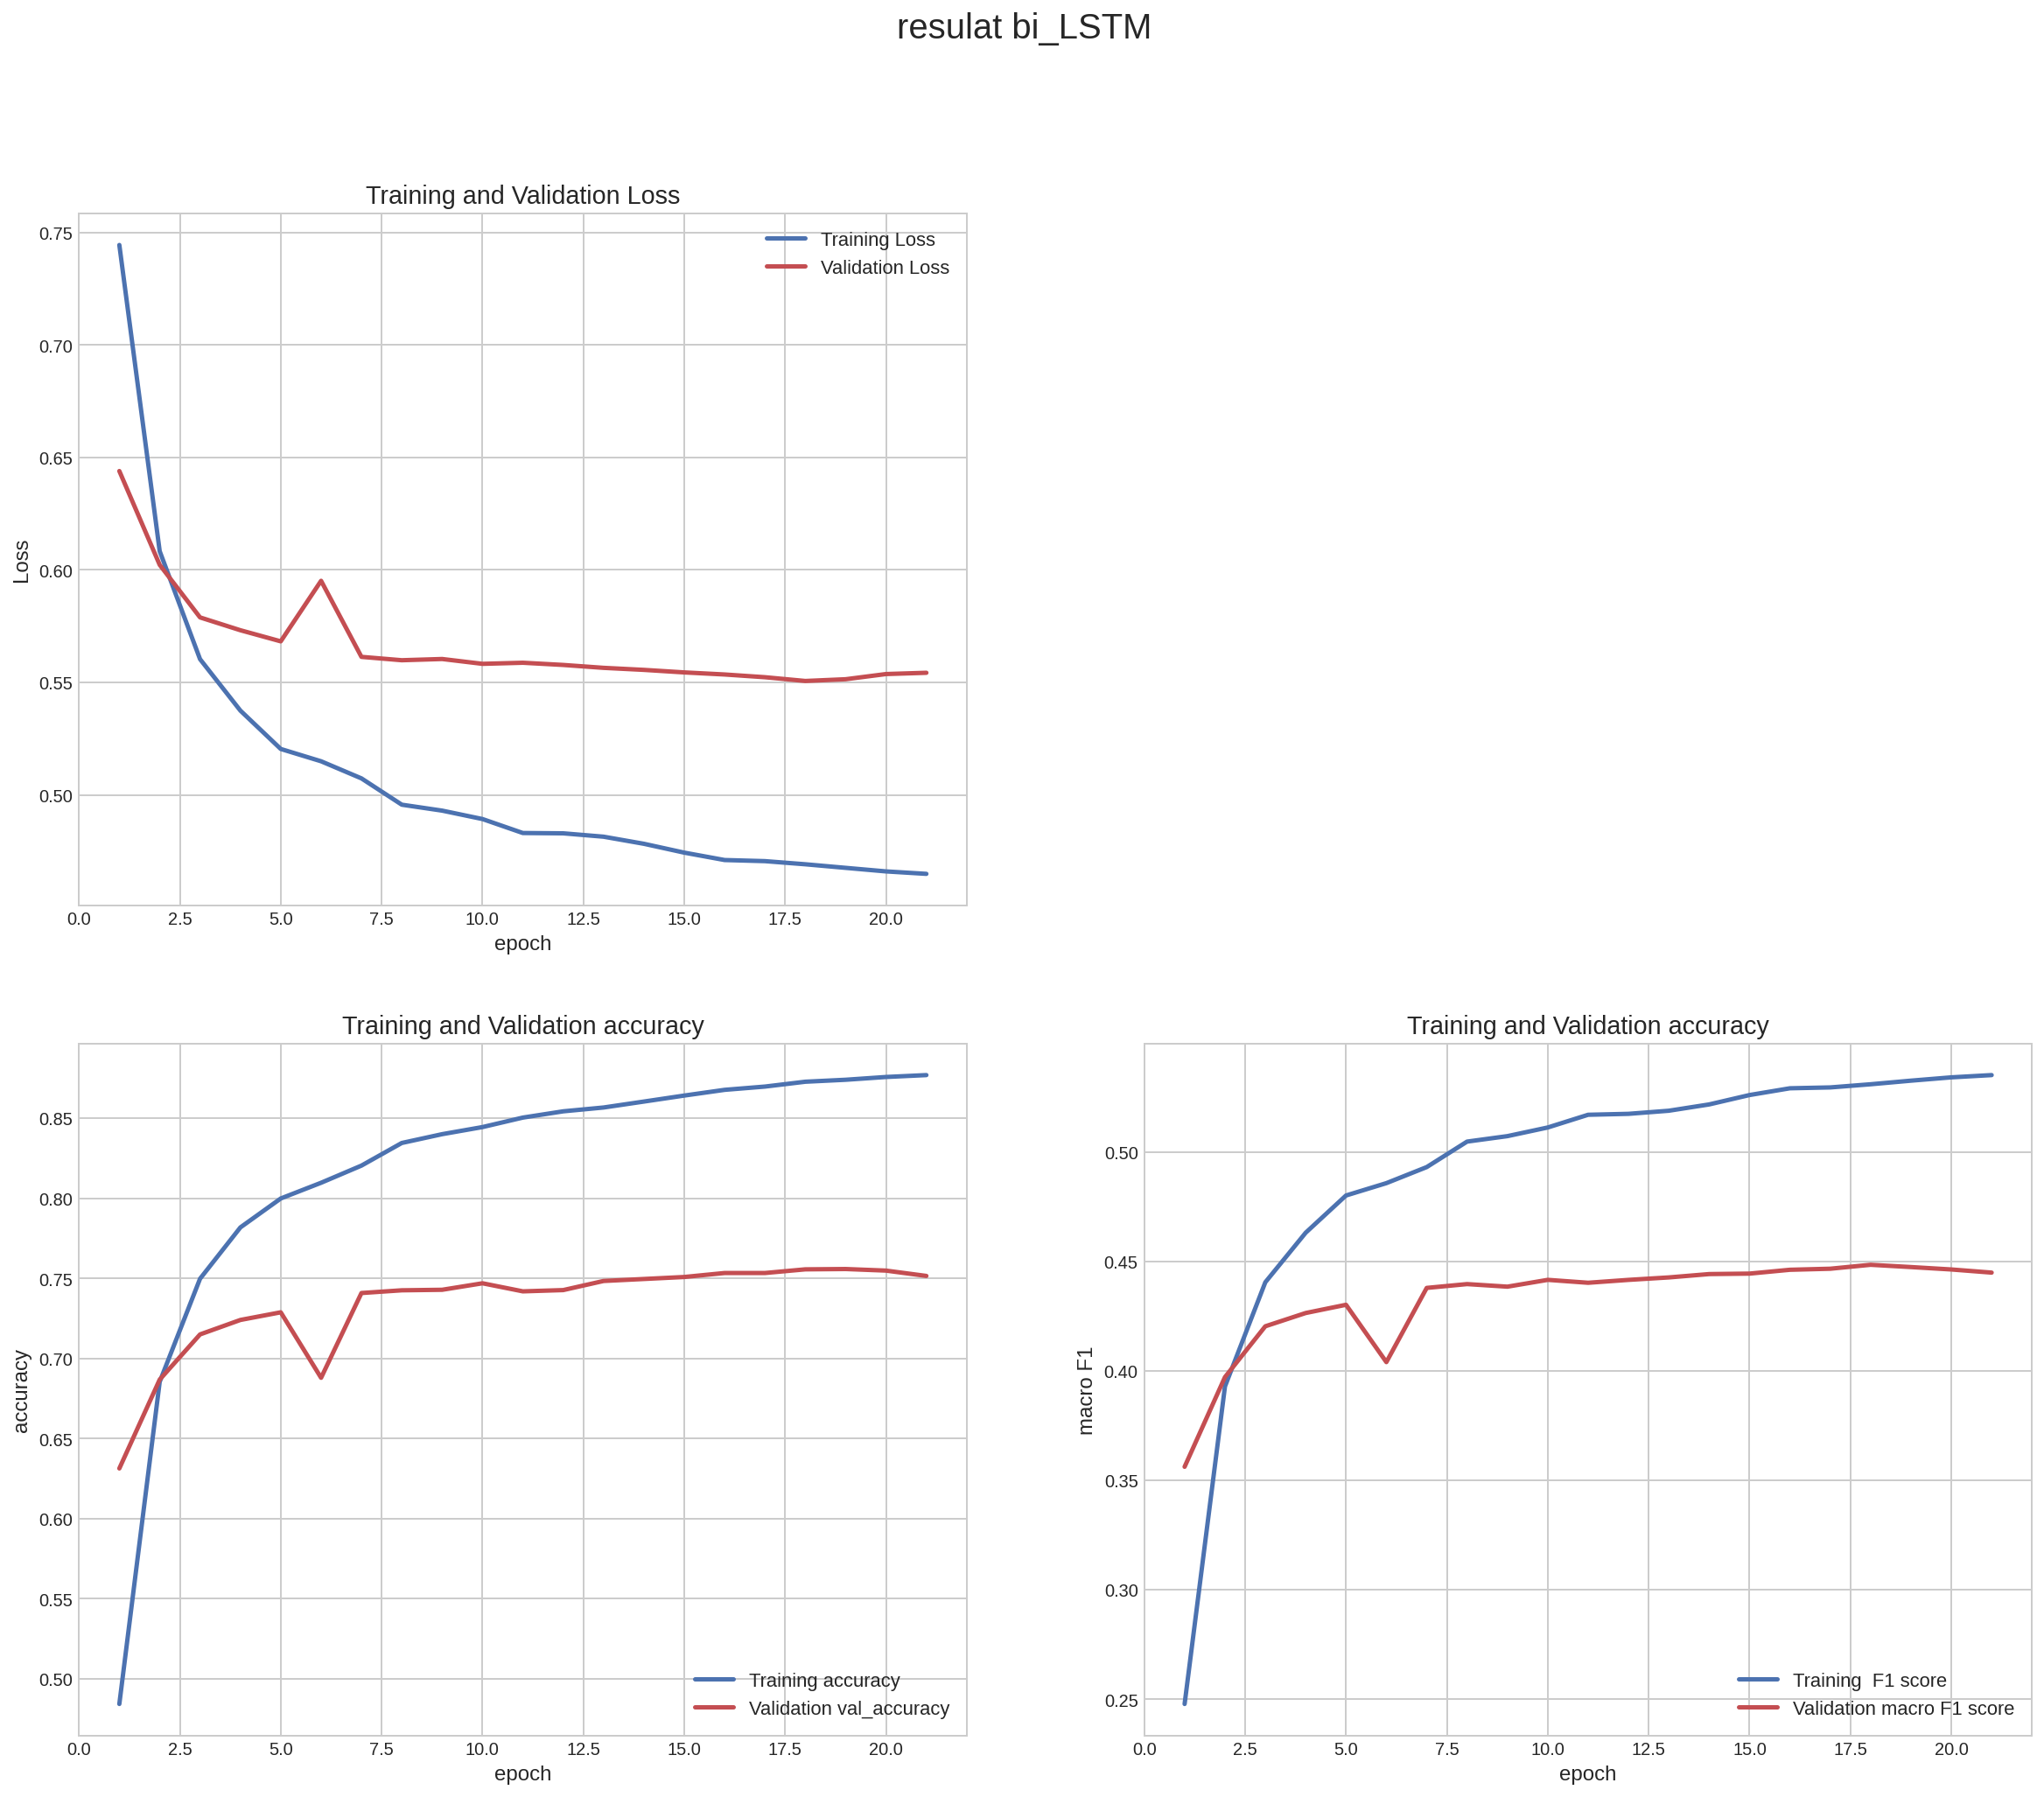

In [ ]:
learning_curves(history_bi_lstm, "resulat bi_LSTM")

Predictions sur l'ensemble test

In [ ]:
preds2=bi_lstm(X_test)
test_pred_class = np.argmax(preds2.numpy(),axis = 1)
y_test_class = np.argmax(np.asarray(y_test_ohe),axis = 1)

Matrice de Confusion

In [ ]:

from sklearn import metrics
import itertools
def cm(y_test,test_pred):

  cnf_matrix = metrics.confusion_matrix(y_test, test_pred)

  ###Optionnel: Afficher une matrice de confusion sous forme de tableau coloré
  classes = range(0,27)

  plt.figure(figsize=(20,20))
  plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
  plt.title("Matrice de confusion")
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)

  for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      plt.text(j, i, cnf_matrix[i, j],
              horizontalalignment = "center",
              color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

  plt.ylabel('Vrais labels')
  plt.xlabel('Labels prédits')
  plt.show()
  

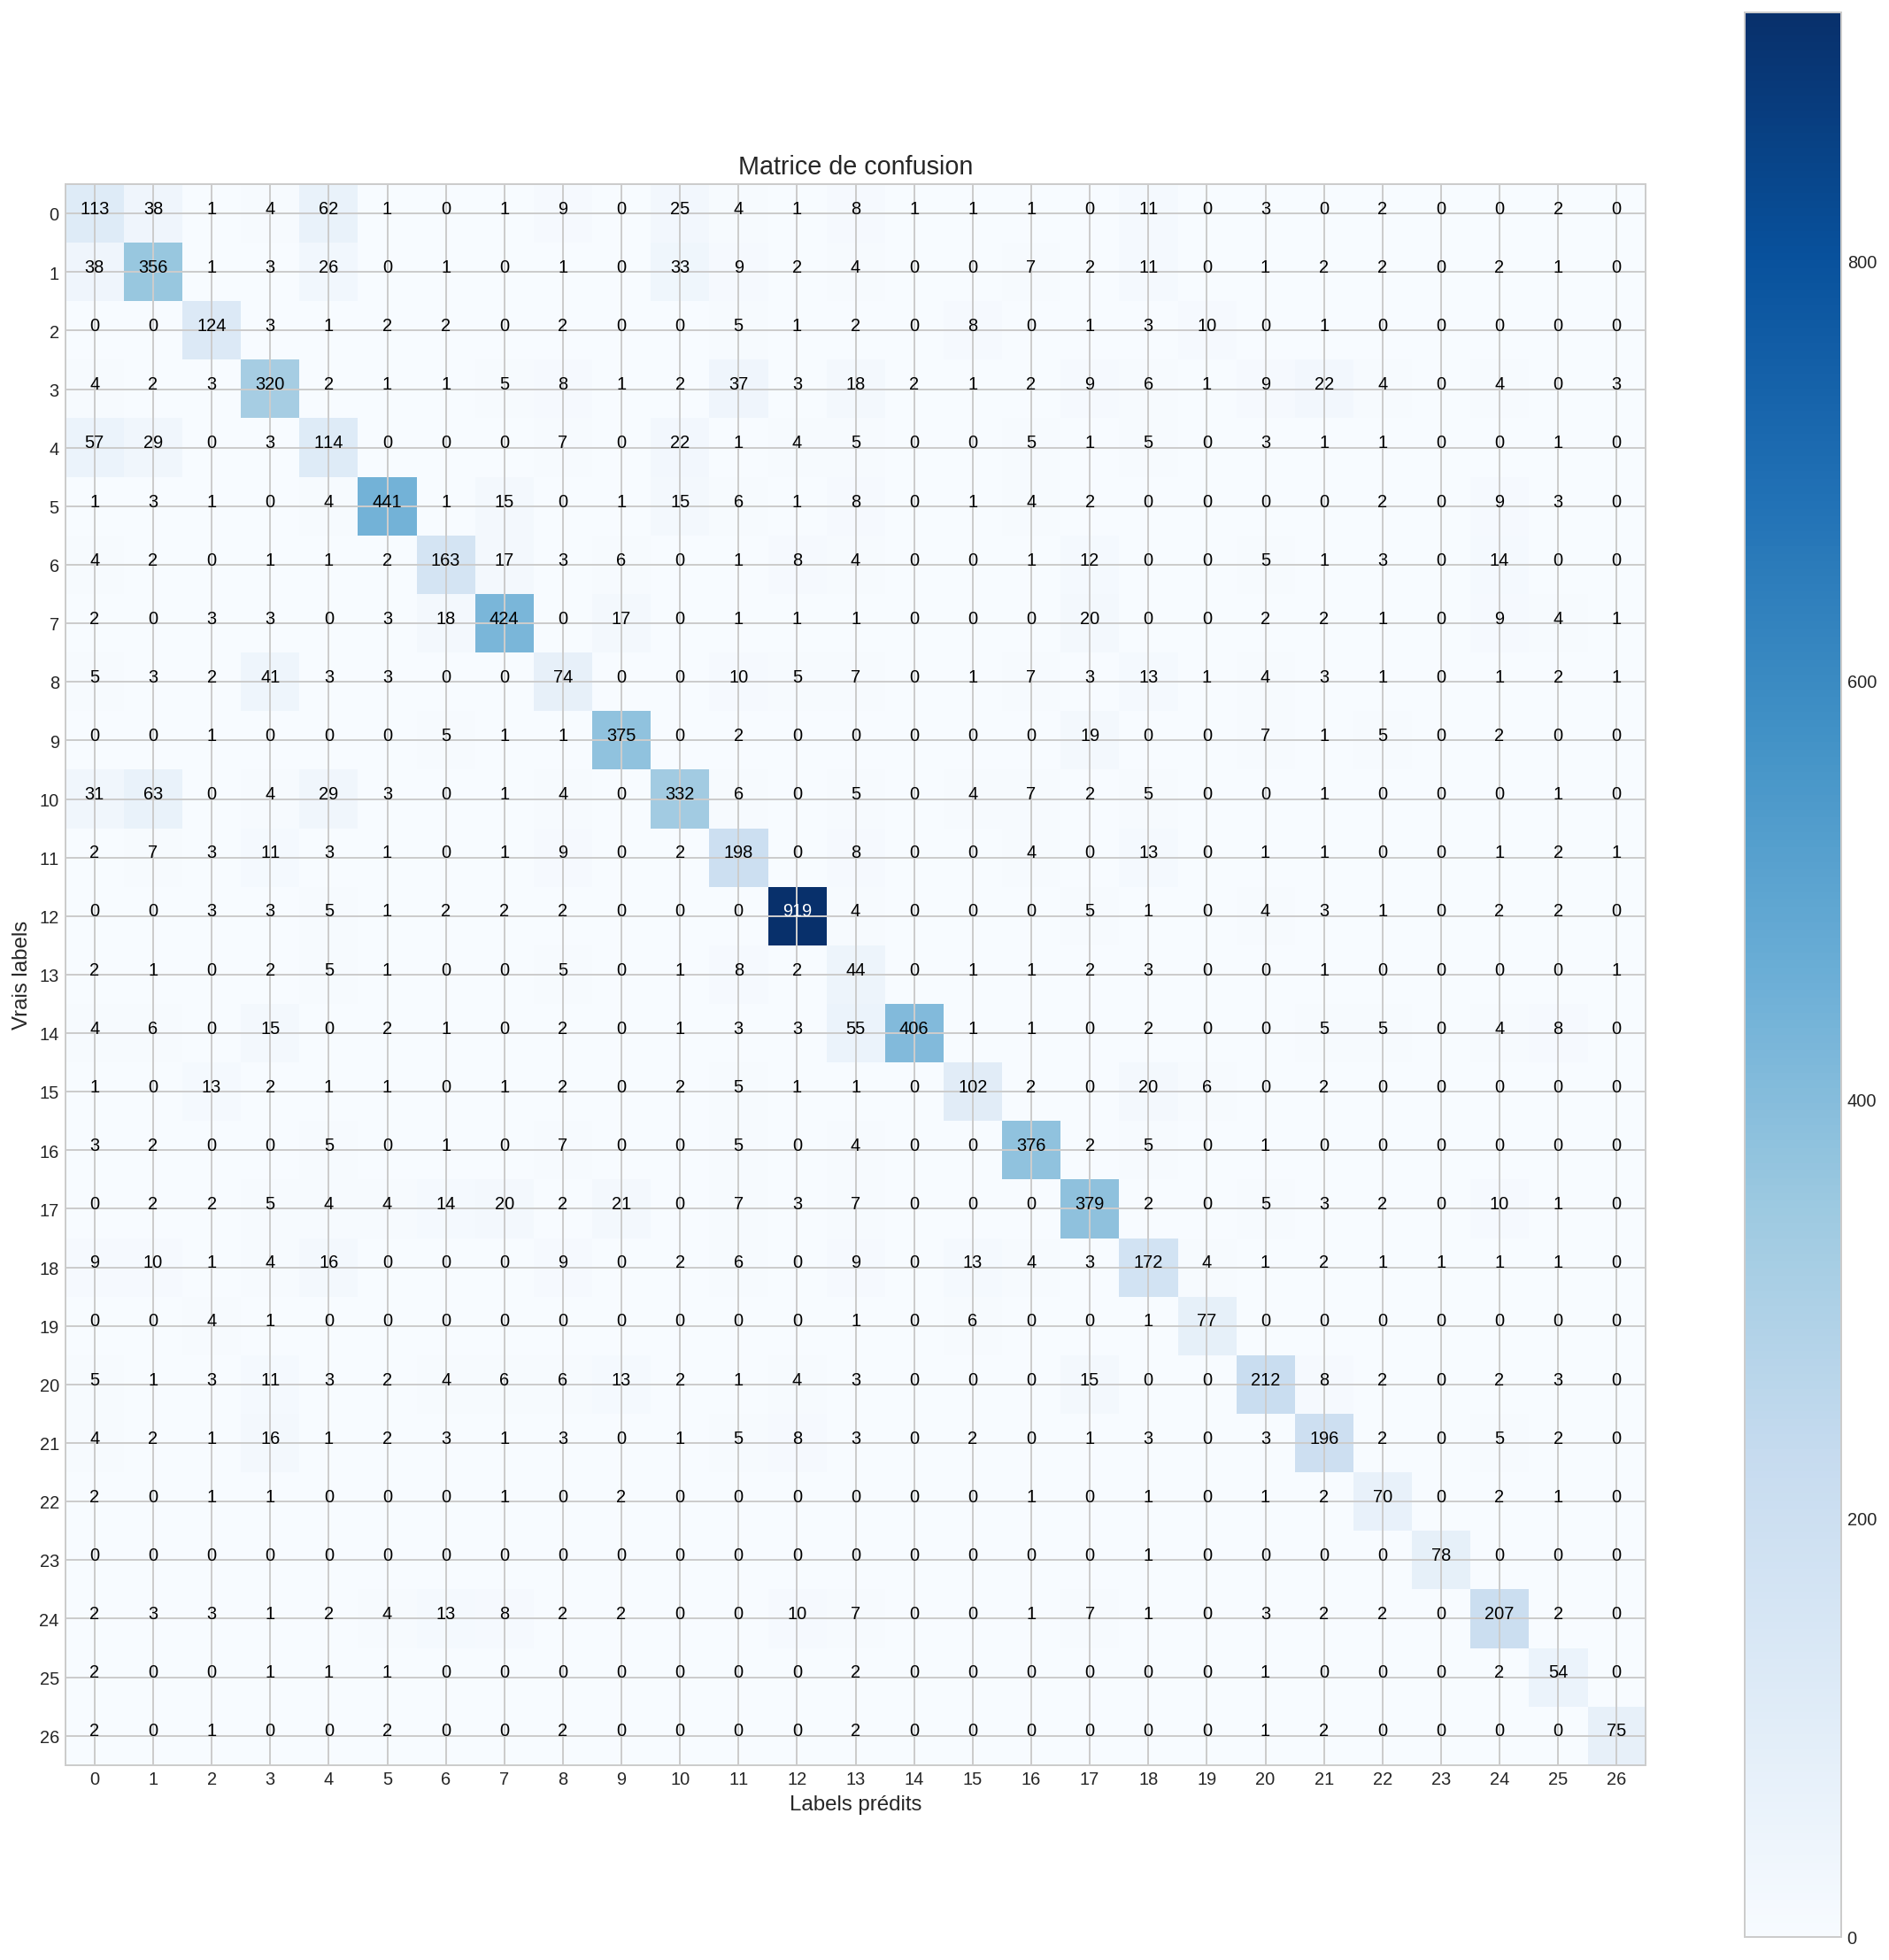

In [ ]:
cm(y_test_class,test_pred_class)

In [ ]:
cnf_matrix = metrics.confusion_matrix(y_test_class,test_pred_class)
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
      if(cnf_matrix[i,j] >20 and i!=j):
          print("La classe {0} a souvent été prise pour la classe {1} , nb d'erreurs = {2}".format(i,j,cnf_matrix[i,j]))

La classe 0 a souvent été prise pour la classe 1 , nb d'erreurs = 38
La classe 0 a souvent été prise pour la classe 4 , nb d'erreurs = 62
La classe 0 a souvent été prise pour la classe 10 , nb d'erreurs = 25
La classe 1 a souvent été prise pour la classe 0 , nb d'erreurs = 38
La classe 1 a souvent été prise pour la classe 4 , nb d'erreurs = 26
La classe 1 a souvent été prise pour la classe 10 , nb d'erreurs = 33
La classe 3 a souvent été prise pour la classe 11 , nb d'erreurs = 37
La classe 3 a souvent été prise pour la classe 21 , nb d'erreurs = 22
La classe 4 a souvent été prise pour la classe 0 , nb d'erreurs = 57
La classe 4 a souvent été prise pour la classe 1 , nb d'erreurs = 29
La classe 4 a souvent été prise pour la classe 10 , nb d'erreurs = 22
La classe 8 a souvent été prise pour la classe 3 , nb d'erreurs = 41
La classe 10 a souvent été prise pour la classe 0 , nb d'erreurs = 31
La classe 10 a souvent été prise pour la classe 1 , nb d'erreurs = 63
La classe 10 a souvent été 

### **5. Conclusion**



*   Ce modèle a commis moins d'erreurs de classification que les autres modèles de la partie 1, il semble assez efficace sur les données entières de ce dataset 
*   L'association de ce modèle avec la minimisation de la F1 loss a permis de faire face au déséquilibre des données. Le même modèle a donné de moins bon résultat en minimisant la "CategoricalCrossentropy"
*   L'optimizer "Nadam" a également donné de meilleurs résultats , que Adam et SDG, cet optimizer est un adam amélioré puisque:  
  1. Adam applique multiplie le lerning rate par un momentum (qui dependant du gradient) qui va adapter l'acceleration de la descente de gradient selon si l'on est proche ou non du minimum local. 
  2. Nadam est une descente de gradient de Nesterov qui se déplace de "deux pas" dans la descente de gradient, il calcule d'abord un point intermediaire grace au momentum, puis applique la descente de gradient à partir de ce point.  



